# Set Up

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

train_set = torchvision.datasets.FashionMNIST(root = ".", train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
# Fix the seed to be able to get the same randomness across runs 
# and hence reproducible outcomes
torch.manual_seed(0)

# If you are using CuDNN , otherwise you can just ignore
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

## 3.2: Network Design and Implementation

The design of the network is:

1. Input image size: 28 × 28 × 1 (height × width × number of channels).
2. First convolutional layer: Kernel size (5 × 5), Stride size (1 × 1) and 32 output channels.
Activation function.
3. Max pooling layer: Kernel size (2 × 2) and Stride size (2 × 2).
4. Second convolutional layer: Kernel size (5×5), Stride size (1 × 1) and 64 output channels.
Activation function.
5. Max pooling layer: Kernel size (2 × 2) and Stride size (2 × 2).
6. First fully-connected layer with input size being the output size of max pooling layer in 5.
(flattened, i.e. 1024) and output size 1024. Activation function.
7. Second fully-connected layer with input size being the output size of fully connected layer in
6. (i.e. 1024) and output size 256. Activation function.
8. Output layer with input size being the output size of fully-connected layer in 7. (i.e. 256)
and output size 10.


In [2]:
class CNN_Relu(nn.Module):
    def __init__(self):
        super(CNN_Relu, self).__init__()
        #CNN layers
        #First Conv Layer: number of input channels, number of output channels, kernel size, stride
        #Activation function (introduces non-linearity)
        #max pooling layer (dimensionality reduction)
        #2nd conv layer, activation, and pooling layer
        self.cnn_model = nn.Sequential(nn.Conv2d(1, 32,  kernel_size=5, stride=1),
                                    nn.ReLU(), nn.MaxPool2d(2,stride=2),
                                    nn.Conv2d(32, 64, kernel_size=5, stride=1),
                                    nn.ReLU(),nn.MaxPool2d(2,stride=2))
        ##Fully connected model
        #Linear layer with input equal to number of elements in output from final max pooling layer
        #activation function
        #second linear layer, activation, then final linear layer
        #output equal to the number of classes in the dataset
        self.fc_model = nn.Sequential(nn.Linear(1024,1024), nn.ReLU(), nn.Linear(1024,256), 
                                      nn.ReLU(), nn.Linear(256,10))
        
    def forward(self, x):
        #apply convolutional layers
        x = self.cnn_model(x)
        #flatten output of cnn to vector
        x = x.view(x.size(0), -1)
        #input to fc layers
        x = self.fc_model(x)
        return x

In [3]:
def evaluation(dataloader, device, model):
    #setting seeds in functions as seeds in initial code block were not allowing for reproducible results
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
    
    total, correct = 0,0
    #putting network into eval mode deactivates dropout for testing
    #Was recommended as dropout serves a dif purpose in training than testing, hence stopping it
    model.eval()
    
    for batch in dataloader:
        inputs, labels = batch
        #Need to place data on GPU for optimal performance
        inputs, labels = inputs.to(device), labels.to(device)
        #calculate output for test batch
        outputs = model(inputs)
        #Using softmax as specified for classification problems from other course (Machine Learning)
        #transforms the output values corresponding to each class to a probability dist
        sm_out = torch.softmax(outputs.data,dim=1)

        #Assigns predictions by finding indices corresponding to class output with highest prob
        #cumulatively adds batch size and number of correct labels to calc accuracy
        _, pred = torch.max(sm_out,1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        
    return 100*correct/total 

For training, initialise your weights using the Xavier Uniform initialisation, use ReLU as the
activation function, a learning rate of 0.1 with the SGD optimiser. You will train your neural
network for 30 epochs. In your report, provide the following: (a) final (train and test) accuracy
obtained; (b) plot of the accuracy on the training and test sets per each epoch, comment on the
speed of performance changes across epochs; (c) plot of the train loss per epoch (total sum of
per batch losses for each epoch) and comment on the speed of decrease

In [4]:
def weights_init(m):
    #only initialize layers Linear and convolutional layers 
    #not needed in max pooling or activation functions as they do not have weights to update
    if isinstance(layer, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

The following function condenses the training process to avoid clutter. Inputs are:

device: GPU

model: the model to train

alpha: learning rate


In [5]:
def train_loop(device, model, alpha):
    #setting seeds in functions as seeds in initial code block were not allowing for reproducible results
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

    #defining loss function and moving to device
    loss_fn = nn.CrossEntropyLoss()
    loss_fn.to(device)

    #defining optimizer. Pass in model parameters and learning rate
    opt = torch.optim.SGD(list(model.parameters()),lr = alpha)

    #define number of iterations through entire dataset and variables used to store
    #training/performance metrics
    loss_epoch_array = []
    max_epochs = 30
    loss_epoch = 0
    train_accuracy = []
    test_accuracy = []
    #begin training
    for epoch in range(max_epochs):
        loss_epoch = 0
        for i, data in enumerate(train_loader, 0):
            #need to put into training mode to activate dropout
            model.train()
            inputs, labels = data
            #put train data on device
            inputs, labels = inputs.to(device), labels.to(device)
            
            #zero gradient
            opt.zero_grad()
            #compute model out on training data
            outputs = model(inputs)
            #compute loss
            loss = loss_fn(outputs, labels)
            #calculate gradient
            loss.backward()
            #update model weights based on gradient
            opt.step()
            
            #add batch loss to cumulative total epoch loss
            old_loss = loss_epoch
            loss_epoch += loss.item()
                

        #append epoch loss and train/test accuracy to result arrays
        loss_epoch_array.append(loss_epoch)
        train_accuracy.append(evaluation(train_loader, device ,model))
        test_accuracy.append(evaluation(test_loader, device ,model))
        print("Epoch {}: loss: {}, train accuracy: {}, test accuracy:{}"
                  .format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
    
    return train_accuracy, test_accuracy, loss_epoch_array

In [ ]:
alpha = .1
device = torch.device("cuda:0")
model1 = CNN_Relu().to(device)

train_acc_1, test_acc_1, train_loss_1 = train_loop(device, model1, alpha)

Epoch 1: loss: 1133.3834626674652, train accuracy: 85.32, test accuracy:84.52
Epoch 2: loss: 627.0065721869469, train accuracy: 88.19833333333334, test accuracy:87.14


In [ ]:
print('ReLU Activation \nFinal Train accuracy is: {0} \nFinal Test Accuracy is: {1}  '
                          .format(train_acc_1[-1],test_acc_1[-1] ))

In [ ]:
#Accuracy plot
epochs = len(train_acc_1)
x_plot = range(1,epochs+1)

plt.plot(x_plot,train_acc_1, label='Train Accuracy')
plt.plot(x_plot,test_acc_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('% Accurate')
plt.xticks(x_plot, x_plot)
plt.legend()

plt.show()


In [ ]:
plt.plot(x_plot,train_loss_1, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.xticks(x_plot, x_plot)
plt.legend()

plt.show()

## Comparison of Activation Functions

Run three experiments each time changing all the current activation functions to one of the
following: Tanh, Sigmoid and ELU. In your report, provide only the final classification accuracy
values (train and test) per activation function and comment on the result

The following three cells contain modeles that are identical to model in 3.2, but have **updated activation functions**

In [ ]:
class CNN_Tanh(nn.Module):
    def __init__(self):
        super(CNN_Tanh, self).__init__()
        #Conv Layers
        self.cnn_model = nn.Sequential(nn.Conv2d(1, 32,  kernel_size=5, stride=1),
                                    nn.Tanh(), nn.MaxPool2d(2,stride=2),
                                    nn.Conv2d(32, 64, kernel_size=5, stride=1),
                                    nn.Tanh(),nn.MaxPool2d(2,stride=2))
        #fc layers
        self.fc_model = nn.Sequential(nn.Linear(1024,1024), nn.Tanh(), nn.Linear(1024,256), 
                                      nn.Tanh(), nn.Linear(256,10))
        
    def forward(self, x):
        #apply convolutional layers
        x = self.cnn_model(x)
        #flatten output of cnn to vector
        x = x.view(x.size(0), -1)
        #predictions
        x = self.fc_model(x)
        return x

In [12]:
class CNN_Sig(nn.Module):
    def __init__(self):
        super(CNN_Sig, self).__init__()
        #Conv Layers
        self.cnn_model = nn.Sequential(nn.Conv2d(1, 32,  kernel_size=5, stride=1),
                                    nn.Sigmoid(), nn.MaxPool2d(2,stride=2),
                                    nn.Conv2d(32, 64, kernel_size=5, stride=1),
                                    nn.Sigmoid(),nn.MaxPool2d(2,stride=2))
        #fc layers
        self.fc_model = nn.Sequential(nn.Linear(1024,1024), nn.Sigmoid(), nn.Linear(1024,256), 
                                      nn.Sigmoid(), nn.Linear(256,10))
        
    def forward(self, x):
        #apply convolutional layers
        x = self.cnn_model(x)
        #flatten output of cnn to vector
        x = x.view(x.size(0), -1)
        #predictions
        x = self.fc_model(x)
        return x

In [13]:
class CNN_Elu(nn.Module):
    def __init__(self):
        super(CNN_Elu, self).__init__()
        self.cnn_model = nn.Sequential(nn.Conv2d(1, 32,  kernel_size=5, stride=1),
                                    nn.ELU(), nn.MaxPool2d(2,stride=2),
                                    nn.Conv2d(32, 64, kernel_size=5, stride=1),
                                    nn.ELU(),nn.MaxPool2d(2,stride=2))
        
        self.fc_model = nn.Sequential(nn.Linear(1024,1024), nn.ELU(), nn.Linear(1024,256), 
                                      nn.ELU(), nn.Linear(256,10))
        
    def forward(self, x):
        #apply convolutional layers
        x = self.cnn_model(x)
        #flatten output of cnn to vector
        x = x.view(x.size(0), -1)
        #predictions
        x = self.fc_model(x)
        return x

Train model using Tanh activation

In [15]:
model2 = CNN_Tanh().to(device)

train_acc_2, test_acc_2, _ = train_loop(device, model2, alpha)

Epoch 1: loss: 985.6218835115433, train accuracy: 86.505, test accuracy:85.6
Epoch 2: loss: 640.5114376991987, train accuracy: 87.85666666666667, test accuracy:86.49
Epoch 3: loss: 544.4739246666431, train accuracy: 89.09333333333333, test accuracy:87.44
Epoch 4: loss: 479.8130479976535, train accuracy: 89.985, test accuracy:87.87
Epoch 5: loss: 427.71460864692926, train accuracy: 90.69833333333334, test accuracy:88.16
Epoch 6: loss: 381.95756163913757, train accuracy: 91.56166666666667, test accuracy:88.72
Epoch 7: loss: 339.9176556626335, train accuracy: 92.36166666666666, test accuracy:88.93
Epoch 8: loss: 299.5778840985149, train accuracy: 93.26333333333334, test accuracy:89.36
Epoch 9: loss: 262.85571730323136, train accuracy: 92.90166666666667, test accuracy:88.95
Epoch 10: loss: 230.3099486248102, train accuracy: 93.29833333333333, test accuracy:88.92
Epoch 11: loss: 199.33653113641776, train accuracy: 93.805, test accuracy:89.3
Epoch 12: loss: 178.3883412075229, train accuracy:

Train model using Sigmoid activation

In [17]:
model3 = CNN_Sig().to(device)

train_acc_3, test_acc_3, _ = train_loop(device, model3, alpha)

Epoch 1: loss: 4333.339582681656, train accuracy: 10.0, test accuracy:10.0
Epoch 2: loss: 4320.285849809647, train accuracy: 10.0, test accuracy:10.0
Epoch 3: loss: 4319.466145992279, train accuracy: 10.0, test accuracy:10.0
Epoch 4: loss: 4319.16738152504, train accuracy: 10.0, test accuracy:10.0
Epoch 5: loss: 4318.97681593895, train accuracy: 10.0, test accuracy:10.0
Epoch 6: loss: 4318.770339488983, train accuracy: 10.0, test accuracy:10.0
Epoch 7: loss: 4318.372188568115, train accuracy: 10.0, test accuracy:10.0
Epoch 8: loss: 4316.777485847473, train accuracy: 10.0, test accuracy:10.0
Epoch 9: loss: 4203.1879559755325, train accuracy: 27.248333333333335, test accuracy:27.34
Epoch 10: loss: 2459.954457104206, train accuracy: 64.93833333333333, test accuracy:64.89
Epoch 11: loss: 1627.5491960346699, train accuracy: 70.56833333333333, test accuracy:70.66
Epoch 12: loss: 1401.296587318182, train accuracy: 73.76833333333333, test accuracy:73.59
Epoch 13: loss: 1250.207246184349, train

Train Model using Elu activation

In [19]:
model4 = CNN_Elu().to(device)

train_acc_4, test_acc_4, _ = train_loop(device, model4, alpha)

Epoch 1: loss: 976.3634717538953, train accuracy: 85.985, test accuracy:85.08
Epoch 2: loss: 635.4865176454186, train accuracy: 87.835, test accuracy:86.59
Epoch 3: loss: 543.8896478302777, train accuracy: 89.035, test accuracy:87.55
Epoch 4: loss: 482.93272753059864, train accuracy: 89.97833333333334, test accuracy:88.03
Epoch 5: loss: 433.8611575551331, train accuracy: 90.925, test accuracy:88.66
Epoch 6: loss: 390.2348792143166, train accuracy: 91.92166666666667, test accuracy:89.22
Epoch 7: loss: 349.965020368807, train accuracy: 92.76666666666667, test accuracy:89.4
Epoch 8: loss: 311.7838448481634, train accuracy: 93.12666666666667, test accuracy:89.38
Epoch 9: loss: 279.8841648339294, train accuracy: 93.83333333333333, test accuracy:89.76
Epoch 10: loss: 262.0243766924832, train accuracy: 94.21333333333334, test accuracy:89.86
Epoch 11: loss: 246.48063692892902, train accuracy: 93.885, test accuracy:89.17
Epoch 12: loss: 224.3188809803687, train accuracy: 93.135, test accuracy:8

Print Final Accuracy Results

In [20]:
print('Tanh Activation \nFinal Train accuracy(%) is: {0} \nFinal Test Accuracy(%) is: {1}  '
                          .format(train_acc_2[-1],test_acc_2[-1] ))

print('Sigmoid Activation \nFinal Train accuracy(%) is: {0} \nFinal Test Accuracy(%) is: {1}  '
                          .format(train_acc_3[-1],test_acc_3[-1] ))

print('ELU Activation \nFinal Train accuracy(%) is: {0} \nFinal Test Accuracy(%) is: {1}  '
                          .format(train_acc_4[-1],test_acc_4[-1] ))

Tanh Activation 
Final Train accuracy(%) is: 98.73333333333333 
Final Test Accuracy(%) is: 90.34  
Sigmoid Activation 
Final Train accuracy(%) is: 87.795 
Final Test Accuracy(%) is: 86.76  
ELU Activation 
Final Train accuracy(%) is: 97.52333333333333 
Final Test Accuracy(%) is: 90.0  


Plot train and test accuracies of the different models in relation to epoch

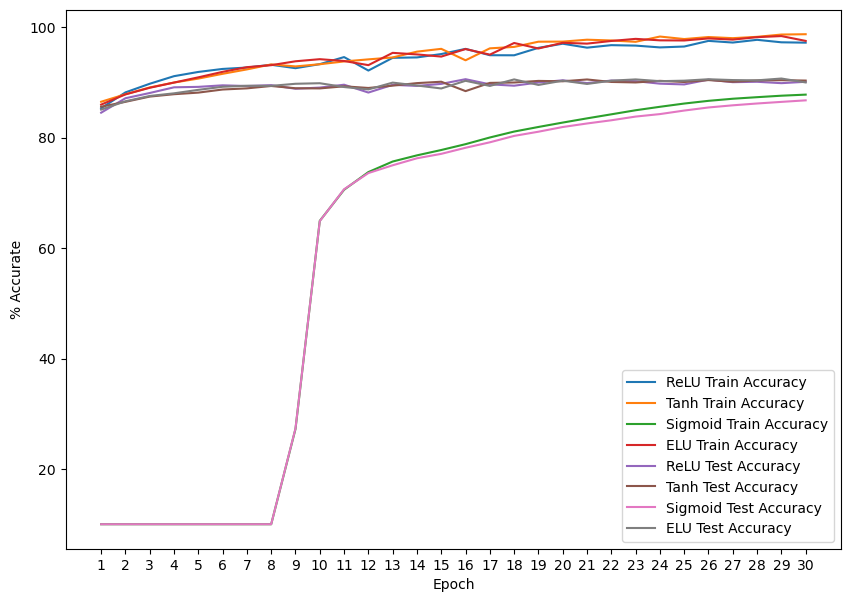

In [21]:
plt.figure(figsize =(10,7))
plt.plot(x_plot,train_acc_1, label='ReLU Train Accuracy')
plt.plot(x_plot,train_acc_2, label='Tanh Train Accuracy')
plt.plot(x_plot,train_acc_3, label='Sigmoid Train Accuracy')
plt.plot(x_plot,train_acc_4, label='ELU Train Accuracy')
plt.plot(x_plot,test_acc_1, label='ReLU Test Accuracy')
plt.plot(x_plot,test_acc_2, label='Tanh Test Accuracy')
plt.plot(x_plot,test_acc_3, label='Sigmoid Test Accuracy')
plt.plot(x_plot,test_acc_4, label='ELU Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('% Accurate')
plt.xticks(x_plot, x_plot)
plt.legend()

plt.show()

## Comparison of Learning Rates

Keeping ReLU, use 5 different learning rates: 0.001, 0.1, 0.5, 1, 10. In your report, provide the
final train loss, as well as the final accuracy values for both train and test for each learning rate
and comment on the trade-offs between speed and stability of convergence. Comment on why
you get the Nan loss if any.

The following 5 cells train Relu CNNs with different learning rates

In [23]:
alpha = .001
model5 = CNN_Relu().to(device)

train_acc_5, test_acc_5, train_loss_5 = train_loop(device, model5, alpha)

Epoch 1: loss: 4293.563386440277, train accuracy: 18.241666666666667, test accuracy:18.43
Epoch 2: loss: 4106.763888120651, train accuracy: 42.68, test accuracy:42.31
Epoch 3: loss: 2541.7486389279366, train accuracy: 63.10166666666667, test accuracy:62.2
Epoch 4: loss: 1759.9088279604912, train accuracy: 67.54166666666667, test accuracy:66.76
Epoch 5: loss: 1576.9267013669014, train accuracy: 70.465, test accuracy:69.88
Epoch 6: loss: 1450.039971768856, train accuracy: 72.34666666666666, test accuracy:71.67
Epoch 7: loss: 1366.905336856842, train accuracy: 73.28666666666666, test accuracy:72.63
Epoch 8: loss: 1312.5661469697952, train accuracy: 74.035, test accuracy:73.27
Epoch 9: loss: 1270.224777624011, train accuracy: 74.665, test accuracy:73.97
Epoch 10: loss: 1233.871644899249, train accuracy: 75.22833333333334, test accuracy:74.71
Epoch 11: loss: 1200.868364468217, train accuracy: 75.76, test accuracy:75.3
Epoch 12: loss: 1169.1946731954813, train accuracy: 76.36166666666666, te

In [25]:
alpha = .5
model6 = CNN_Relu().to(device)

train_acc_6, test_acc_6, train_loss_6 = train_loop(device, model6, alpha)

Epoch 1: loss: 1085.076138973236, train accuracy: 86.95833333333333, test accuracy:85.78
Epoch 2: loss: 643.8510331846774, train accuracy: 86.26666666666667, test accuracy:84.44
Epoch 3: loss: 556.7701644003391, train accuracy: 88.20666666666666, test accuracy:86.38
Epoch 4: loss: 507.64790564216673, train accuracy: 89.25, test accuracy:87.2
Epoch 5: loss: 466.73805799521506, train accuracy: 90.05833333333334, test accuracy:87.5
Epoch 6: loss: 440.3770205769688, train accuracy: 90.97666666666667, test accuracy:87.97
Epoch 7: loss: 411.8412630353123, train accuracy: 91.97166666666666, test accuracy:88.48
Epoch 8: loss: 404.59957944601774, train accuracy: 92.21166666666667, test accuracy:88.61
Epoch 9: loss: 388.1862058164552, train accuracy: 91.74, test accuracy:87.59
Epoch 10: loss: 411.0600092597306, train accuracy: 92.46833333333333, test accuracy:88.32
Epoch 11: loss: 368.47144618444145, train accuracy: 92.72666666666667, test accuracy:88.48
Epoch 12: loss: 372.24310168088414, train

In [27]:
alpha = 1
model7 = CNN_Relu().to(device)

train_acc_7, test_acc_7, train_loss_7 = train_loop(device, model7, alpha)

Epoch 1: loss: 4340.588634252548, train accuracy: 10.0, test accuracy:10.0
Epoch 2: loss: 4331.743026256561, train accuracy: 10.0, test accuracy:10.0
Epoch 3: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 4: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 5: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 6: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 7: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 8: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 9: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 10: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 11: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 12: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 13: loss: 4331.705075979233, train accuracy: 10.0, test accuracy:10.0
Epoch 14: loss: 4331.

In [29]:
alpha = 10
model8 = CNN_Relu().to(device)

train_acc_8, test_acc_8, train_loss_8 = train_loop(device, model8, alpha)

Epoch 1: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 2: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 3: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 4: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 5: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 6: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 7: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 8: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 9: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 10: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 11: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 12: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 13: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 14: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 15: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 16: loss: nan, train accuracy: 10.0, test accuracy:10.0
Epoch 17: loss: n

Print train and test accuracies

In [30]:
print('Learning Rate: .001 \nFinal Train accuracy is: {0} \nFinal Test Accuracy is: {1}  '
                          .format(train_acc_5[-1],test_acc_5[-1] ))

print('Learning Rate: .1 \nFinal Train accuracy is: {0} \nFinal Test Accuracy is: {1}  '
                          .format(train_acc_1[-1],test_acc_1[-1] ))

print('Learning Rate: .5 \nFinal Train accuracy is: {0} \nFinal Test Accuracy is: {1}  '
                          .format(train_acc_6[-1],test_acc_6[-1] ))

print('Learning Rate: 1 \nFinal Train accuracy is: {0} \nFinal Test Accuracy is: {1}  '
                          .format(train_acc_7[-1],test_acc_7[-1] ))

print('Learning Rate: 10 \nFinal Train accuracy is: {0} \nFinal Test Accuracy is: {1}  '
                          .format(train_acc_8[-1],test_acc_8[-1] ))

Learning Rate: .001 
Final Train accuracy is: 83.91 
Final Test Accuracy is: 83.08  
Learning Rate: .1 
Final Train accuracy is: 97.205 
Final Test Accuracy is: 90.12  
Learning Rate: .5 
Final Train accuracy is: 10.0 
Final Test Accuracy is: 10.0  
Learning Rate: 1 
Final Train accuracy is: 10.0 
Final Test Accuracy is: 10.0  
Learning Rate: 10 
Final Train accuracy is: 10.0 
Final Test Accuracy is: 10.0  


Plot train and test accuracies for the models in relation to epoch

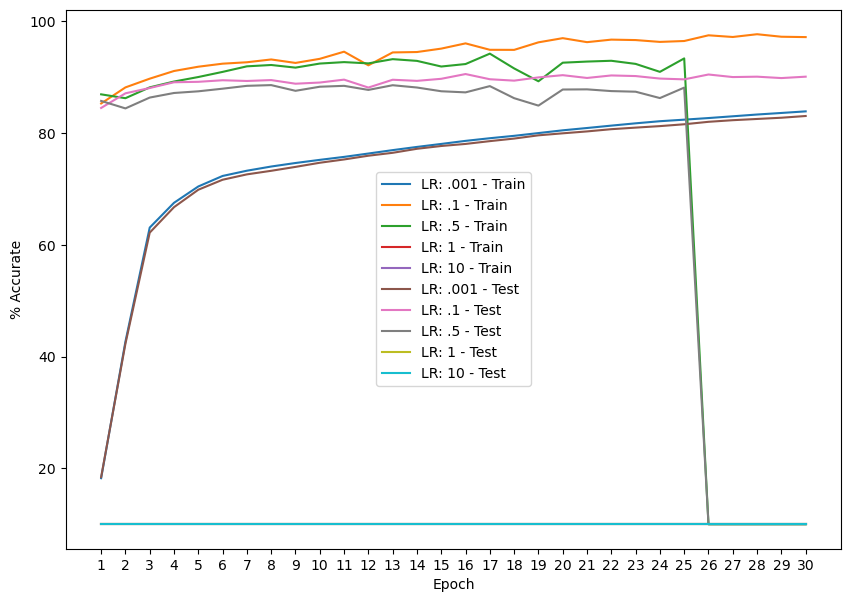

In [31]:
plt.figure(figsize =(10,7))
plt.plot(x_plot,train_acc_5, label='LR: .001 - Train')
plt.plot(x_plot,train_acc_1, label='LR: .1 - Train')
plt.plot(x_plot,train_acc_6, label='LR: .5 - Train')
plt.plot(x_plot,train_acc_7, label='LR: 1 - Train')
plt.plot(x_plot,train_acc_8, label='LR: 10 - Train')
plt.plot(x_plot,test_acc_5, label='LR: .001 - Test')
plt.plot(x_plot,test_acc_1, label='LR: .1 - Test')
plt.plot(x_plot,test_acc_6, label='LR: .5 - Test')
plt.plot(x_plot,test_acc_7, label='LR: 1 - Test')
plt.plot(x_plot,test_acc_8, label='LR: 10 - Test')
plt.xlabel('Epoch')
plt.ylabel('% Accurate')
plt.xticks(x_plot, x_plot)
plt.legend()

plt.show()

Plot train loss in relation to epoch for each model

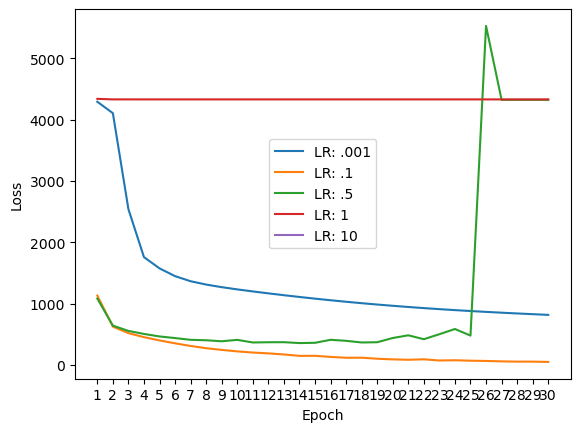

In [32]:
fig, ax = plt.subplots()
ax.plot(x_plot,train_loss_5, label='LR: .001')
ax.plot(x_plot,train_loss_1, label='LR: .1')
ax.plot(x_plot,train_loss_6, label='LR: .5')
ax.plot(x_plot,train_loss_7, label='LR: 1')
ax.plot(x_plot,train_loss_8, label='LR: 10')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xticks(x_plot, x_plot)
ax.ticklabel_format(axis='y',style='plain')
ax.legend()

plt.show()

## Dropout

In [33]:
  class CNN_Relu_Drop(nn.Module):
    def __init__(self):
        super(CNN_Relu_Drop, self).__init__()

        self.cnn_model = nn.Sequential(nn.Conv2d(1, 32,  kernel_size=5, stride=1),
                                    nn.ReLU(), nn.MaxPool2d(2,stride=2),
                                    nn.Conv2d(32, 64, kernel_size=5, stride=1),
                                    nn.ReLU(),nn.MaxPool2d(2,stride=2))
        
        #adding dropout after second fully connected layer
        self.fc_model = nn.Sequential(nn.Linear(1024,1024), nn.ReLU(), nn.Linear(1024,256), 
                                      nn.ReLU(), nn.Dropout(.3), nn.Linear(256,10))
        
    def forward(self, x):
        #apply convolutional layers
        x = self.cnn_model(x)
        #flatten output of cnn to vector
        x = x.view(x.size(0), -1)
        #predictions
        x = self.fc_model(x)
        return x

Train model with dropout

In [35]:
alpha = .1
model9 = CNN_Relu_Drop().to(device)

train_acc_9, test_acc_9, train_loss_9 = train_loop(device, model9, alpha)

Epoch 1: loss: 1186.0625440999866, train accuracy: 84.605, test accuracy:83.9
Epoch 2: loss: 658.1151169538498, train accuracy: 87.20166666666667, test accuracy:86.17
Epoch 3: loss: 539.5818501412868, train accuracy: 88.815, test accuracy:87.39
Epoch 4: loss: 464.3694745451212, train accuracy: 90.45833333333333, test accuracy:88.53
Epoch 5: loss: 403.41868568211794, train accuracy: 92.01333333333334, test accuracy:89.74
Epoch 6: loss: 348.3935996843502, train accuracy: 92.05666666666667, test accuracy:89.57
Epoch 7: loss: 299.38632907159626, train accuracy: 93.12833333333333, test accuracy:90.28
Epoch 8: loss: 254.47916774312034, train accuracy: 93.245, test accuracy:89.94
Epoch 9: loss: 221.58292053360492, train accuracy: 93.81833333333333, test accuracy:90.27
Epoch 10: loss: 208.75425407849252, train accuracy: 92.625, test accuracy:89.45
Epoch 11: loss: 176.5732305929996, train accuracy: 93.49666666666667, test accuracy:90.0
Epoch 12: loss: 165.74522849777713, train accuracy: 94.1166

Results. Same print statement and plot format as before

In [36]:
print('ReLU With Dropout \nFinal Train accuracy is: {0} \nFinal Test Accuracy is: {1}  '
                          .format(train_acc_9[-1],test_acc_9[-1] ))

ReLU With Dropout 
Final Train accuracy is: 96.31666666666666 
Final Test Accuracy is: 90.49  


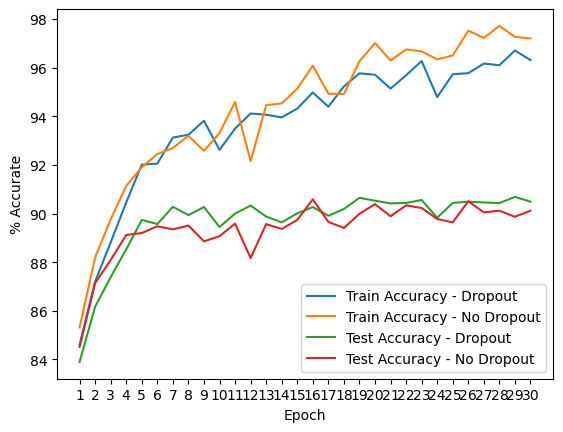

In [37]:
plt.plot(x_plot,train_acc_9, label='Train Accuracy - Dropout')
plt.plot(x_plot,train_acc_1, label='Train Accuracy - No Dropout')
plt.plot(x_plot,test_acc_9, label='Test Accuracy - Dropout')
plt.plot(x_plot,test_acc_1, label='Test Accuracy - No Dropout')
plt.xlabel('Epoch')
plt.ylabel('% Accurate')
plt.xticks(x_plot, x_plot)
plt.legend()

plt.show()

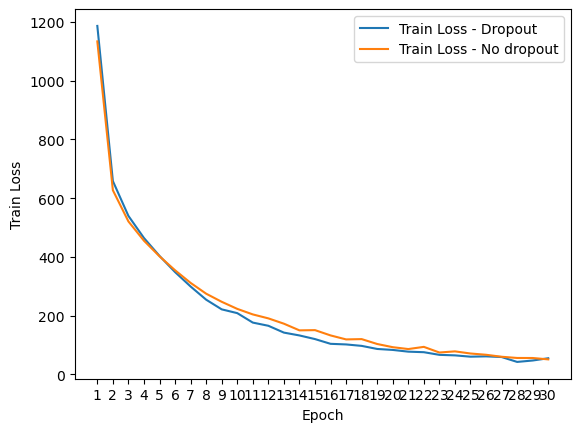

In [38]:
plt.plot(x_plot,train_loss_9, label='Train Loss - Dropout')
plt.plot(x_plot,train_loss_1, label='Train Loss - No dropout')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.xticks(x_plot, x_plot)
plt.legend()

plt.show()